In [1]:
%matplotlib inline
import xgboost
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.metrics import *
import matplotlib.pylab as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Function

In [2]:
# modify dtype 
def str_to_num(df, train=True):
    '''
    ppl_id : del string and change dtype to num
    activity id : del number and str(act)
    type : del string and change dtype to num
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    train : bool
        train :True, test : False
    --------
    '''
    col_list = list(df.columns)
    col_list.remove('date_x')
    col_list.remove('date_y')
    if train:
        col_list.remove('outcome')
        
    for col in col_list[:col_list.index('char_9_y')+1]:
        if col == 'activity_id':
            df[col] = df[col].apply(lambda x: x.split('_')[0])
            df.replace('act', '', regex=True, inplace = True)
        elif col == 'people_id':
            df[col] = df[col].apply(lambda x: x.split('_')[1])
        else :
            df[col][df[col].isnull()==False] = df[col][df[col].isnull()==False].apply(lambda x: x.split(' ')[1])
        df[col][df[col].isnull()==False] = pd.to_numeric(df[col][df[col].isnull()==False]).astype(int)
        
    return df

In [3]:
# add past_says and week
def date_modify(df):
    '''
    add week_x, week_y, and Past_days
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    df.insert(loc=list(df).index('date_x')+1 ,column='week_x', value=df['date_x'].dt.weekday)
    df.insert(loc=list(df).index('date_y')+1 ,column='week_y', value=df['date_y'].dt.weekday)
    df.insert(loc=list(df).index('week_x')+1 ,column='Past_days', value=(df.date_x - df.date_y).astype('timedelta64[D]'))
    return df

In [4]:
# add bool_sum
def add_bool_sum(df):
    '''
    add colum 'bool_sum' : sum of char_10_y ~ char_37
    inplace : False
    
    parameta
    --------
    df : DataFrame 
    --------
    '''
    temp = df.copy()
    temp['bool_sum'] = temp.iloc[:,list(temp).index('char_10_y'):list(temp).index('char_37')].sum(axis=1)
    return temp

In [5]:
def num_to_cat(df, columns, encode=False):
    '''
    change dtype(num to str) and changed columns encoding(one-hot-encoding)
    inplace : True
    
    parameta
    --------
    df : DataFrame 
    columns : list
    encode : bool
        True : one-hot-encoding
    --------
    '''
    temp = df.copy()
    temp[columns] = pd.DataFrame(temp[columns], dtype='str')
    if encode:
        for col in columns:
            for i in list(pd.get_dummies(temp[col]))[-1::-1]:    
                temp.insert(loc=list(temp).index(col)+1 ,column=col+str(i), value=pd.get_dummies(temp[col]).loc[:,i])
            temp.drop([col], axis=1)
    return temp

In [6]:
import io
import pydot
from IPython.core.display import Image 
from sklearn.tree import export_graphviz

# 강사님 함수
def draw_decision_tree(model, feature_names):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

# data load & 전처리

### train data

In [7]:
df_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
df_people = pd.read_csv('./data/people.csv', parse_dates=['date'])
df_merge = pd.merge(df_train, df_people, on='people_id')

In [8]:
str_to_num(df_merge, train=True)
date_modify(df_merge)
df_merge = add_bool_sum(df_merge)
del df_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### test data

In [9]:
df_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
df_merge_test = pd.merge(df_test, df_people, how='inner', on='people_id')

In [10]:
# # submissin 만들때 필요함
# df_test_act_id = df_merge_test.activity_id.copy()

In [11]:
str_to_num(df_merge_test, train=False)
date_modify(df_merge_test)
df_merge_test = add_bool_sum(df_merge_test)
del df_test, df_people

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### save data

In [ ]:
# df_merge.to_csv("train_merge.csv")
# df_merge_test.to_csv("test_merge.csv")

In [ ]:
# df_merge = pd.read_csv('./train_merge.csv', parse_dates=['date_x', 'date_y'])
# df_merge_test = pd.read_csv('./test_merge.csv', parse_dates=['date_x', 'date_y'])

# EDA

In [ ]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(df_merge[d].min().date()))
    print('  End of ' + d + ': ' + str(df_merge[d].max().date()))
    print('Range of ' + d + ': ' + str(df_merge[d].max() - df_merge[d].min()) + '\n')

In [ ]:
df_merge.describe()

In [ ]:
df_merge[['date_x', 'date_y']].describe()

In [ ]:
pd.DataFrame(df_merge.people_id, dtype='object').describe()

In [ ]:
df_merge.people_id.unique()

In [ ]:
# ppl 별 구매 경향
plt.figure(figsize=(20,30))
for i, ppl in enumerate(df_merge.people_id.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
df_merge.people_id.value_counts().head()

In [ ]:
# ppl 별 구매 경향 top 5
plt.figure(figsize=(20,10))
for i, ppl in enumerate([294918, 370270, 105739, 54699, 64887]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.people_id == ppl]['Past_days'], \
                df_merge[df_merge.people_id == ppl].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향
plt.figure(figsize=(20,30))
for i, group in enumerate(df_merge.group_1.unique()[:20]):
    plt.subplot(10,2,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
# group 별 구매 경향 top 5

plt.figure(figsize=(20,10))
for i, group in enumerate([17304, 667, 8386, 9280,450]):
    plt.subplot(5,1,i+1)    
    plt.scatter(df_merge[df_merge.group_1 == group]['Past_days'], \
                df_merge[df_merge.group_1 == group].outcome, alpha = 0.25) 
    plt.ylim(-0.1,1.1)
plt.show()

In [ ]:
sns.factorplot(x="week_x", y="outcome", row="activity_category", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

In [ ]:
sns.factorplot(x="activity_category", y="outcome", row="week_x", data=df_merge,
               size=2, aspect=3, kind="point")
plt.show()

#### sample

In [ ]:
df_sample = df_merge.sample(frac = 0.1, random_state=0).copy()
df_sample = add_bool_sum(df_sample)

In [ ]:
df_sample2 = df_merge.sample(frac = 0.1, random_state=1).copy()
df_sample2 = add_bool_sum(df_sample2)

In [ ]:
df_sample.groupby(['activity_id', 'activity_category']).count()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['Past_days'])
sns.kdeplot(df_sample[df_sample.outcome==1]['Past_days'])
plt.show()

In [ ]:
plt.figure(figsize=(20,4))
sns.kdeplot(df_sample[df_sample.outcome==0]['week_x'])
sns.kdeplot(df_sample[df_sample.outcome==1]['week_x'])
plt.show()

#### char_1_x ~ char_9_x

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_1_x'):list(df_sample).index('char_9_x')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_2_y ~ char_9_y

In [ ]:
sns.countplot('char_2_y', hue='outcome', data=df_sample)
plt.show

In [ ]:
plt.figure(figsize=(20,12))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_3_y'):list(df_sample).index('char_9_y')+1]):
    plt.subplot(3,3,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

#### char_10_y ~ char_37

In [ ]:
plt.figure(figsize=(20,30))
for i, feat in enumerate(df_sample.columns[list(df_sample).index('char_10_y'):list(df_sample).index('char_37')+1]):
    plt.subplot(7,4,i+1)
    sns.countplot(feat, hue='outcome', data=df_sample)
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot('bool_sum', hue='outcome', data=df_sample)
plt.show()

#### char_38

In [ ]:
facet = sns.FacetGrid(df_sample, hue='outcome', aspect=4)
facet.map(sns.kdeplot, 'char_38', shade=True)
facet.set(xlim=(0, df_sample['char_38'].max()))
facet.add_legend()

plt.show()

In [ ]:
sns.boxplot(x="outcome", y="char_38", data=df_sample)
plt.show()

In [ ]:
del df_sample, df_sample

# feature selection

In [ ]:
model1 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + \
                            char_29 + char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37", data=df_merge)
model2 = sm.OLS.from_formula("outcome ~ bool_sum", data=df_merge)
model3 = sm.OLS.from_formula("outcome ~ char_10_y + char_11 + char_12 + char_13 + char_14 + char_15 + char_16 + char_17 + char_18 + \
                            char_19 + char_20 + char_21 + char_22 + char_23 + char_24 + char_25 + char_26 + char_27 + char_28 + char_29 + \
                            char_30 + char_31 + char_32 + char_33 + char_34 + char_35 + char_36 + char_37 + bool_sum", data=df_merge)
result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()

sm.stats.anova_lm(result1, result2, result3)

In [ ]:
sm.stats.anova_lm(result1)

In [ ]:
sm.stats.anova_lm(result2)

In [ ]:
sm.stats.anova_lm(result3)

In [ ]:
del df_sample, df_sample2

# modeling

#### fillna(0)

In [12]:
df_merge.fillna(0, inplace=True)
df_merge_test.fillna(0, inplace=True)

#### columns

In [13]:
a = list(df_merge)
a.remove('date_x')
a.remove('date_y')
a.remove('bool_sum')
a.remove('outcome')
print(a)

['people_id', 'activity_id', 'week_x', 'Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'group_1', 'char_2_y', 'week_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


In [14]:
b = list(df_merge)
b.remove('date_x')
b.remove('date_y')
b = b[:27]
b.append('bool_sum')
b.remove('outcome')
print(b)

['people_id', 'activity_id', 'week_x', 'Past_days', 'activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'group_1', 'char_2_y', 'week_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'bool_sum']


## 로지스틱 회귀분석

In [ ]:
logit_mod = sm.Logit.from_formula("outcome ~ Past_days + char_38 + bool_sum", data=df_merge)
logit_res = logit_mod.fit(disp=0)
print(logit_res.summary())

## 나이브 베이즈

+ 베르누이 분포 나이브 베이즈 모형

In [ ]:
clf_bern = BernoulliNB().fit(X, y)

In [ ]:
print(classification_report(df_sample2.outcome, clf_bern.predict(df_sample2[df_sample2.columns[-30:-2]])))

+ 가우시안 정규 분포 나이브 베이즈 모형

In [117]:
clf_norm = GaussianNB().fit(df_merge[a], df_merge.outcome)

In [118]:
cvs = cross_val_score(clf_norm, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10)

In [119]:
cvs.mean()

0.88364266041326789

In [120]:
print(classification_report(df_merge.outcome, clf_norm.predict(df_merge[a])))

             precision    recall  f1-score   support

          0       0.89      0.77      0.82   1221794
          1       0.75      0.88      0.81    975497

avg / total       0.83      0.82      0.82   2197291



## 의사 결정 나무

In [90]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_merge[a], df_merge.outcome)

array([ 0.85757049,  0.85100614,  0.83930001,  0.83014798,  0.83864693,
        0.85532101,  0.84532552,  0.77696133,  0.79113175,  0.85260582])

In [21]:
cross_val_score(tree, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89157732818147228

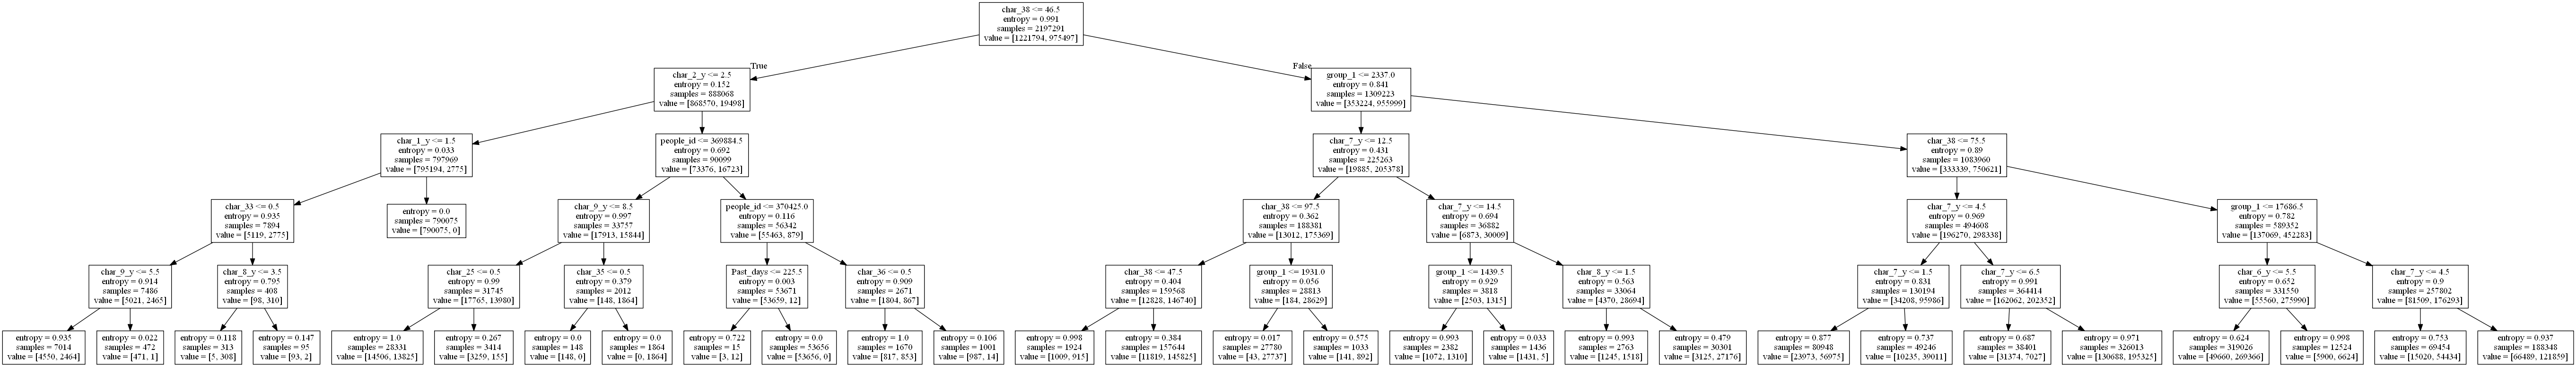

In [16]:
draw_decision_tree(tree, a)

In [18]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(df_merge[b], df_merge.outcome)

In [19]:
cross_val_score(tree2, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

0.89161997940872806

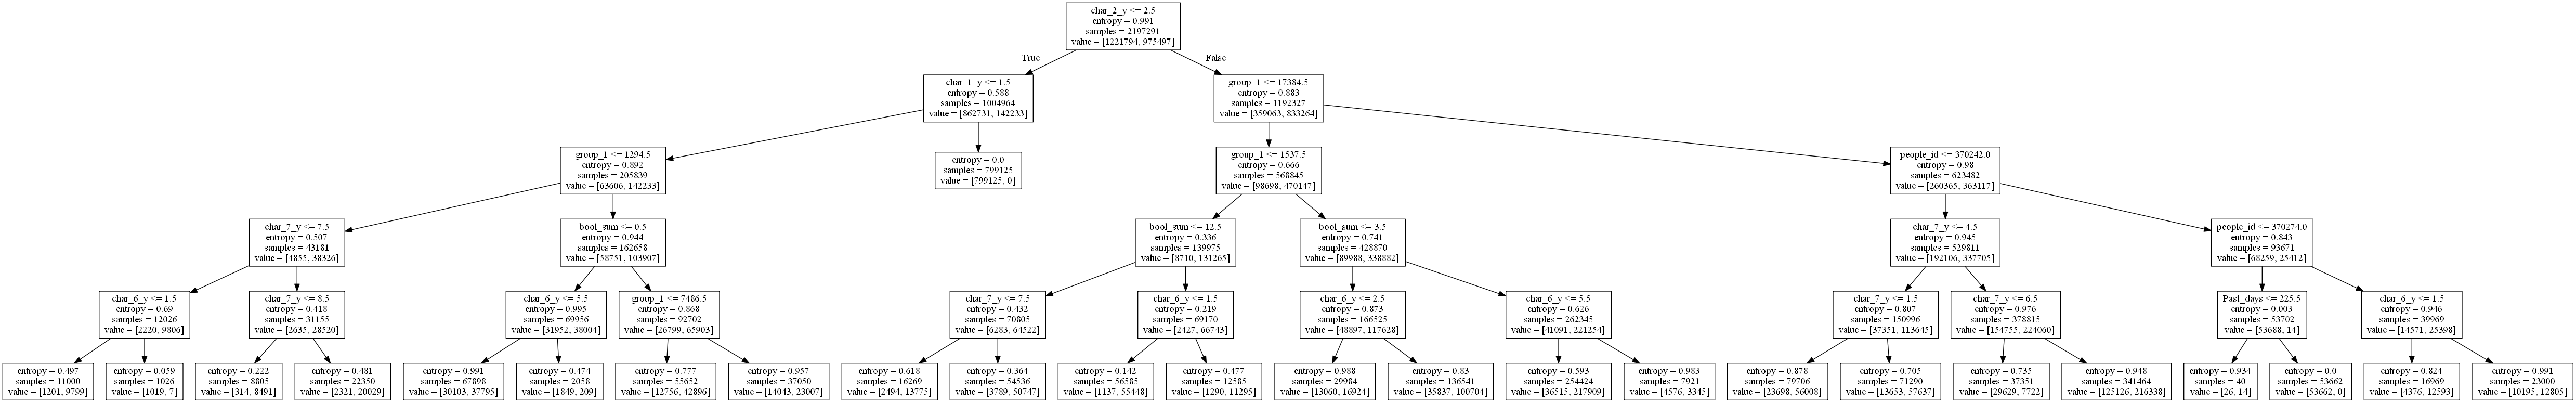

In [20]:
draw_decision_tree(tree2, b)

In [60]:
# tree2 = DecisionTreeClassifier(criterion='entropy').fit(df_merge[a], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree.csv")

In [85]:
# tree2 = DecisionTreeClassifier(criterion='entropy').fit(df_merge[b], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : tree2.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_tree_b.csv")

## 랜덤 포레스트

+ RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(rfc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(rfc, a)

In [ ]:
rfc2 = RandomForestClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(rfc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(rfc2, b)

In [61]:
# rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc.csv")

In [86]:
# rfc = RandomForestClassifier(n_estimators=30).fit(df_merge[b], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : rfc.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_rfc_b.csv")

+ ExtraTreesClassifier

In [ ]:
efc = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(efc, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(efc, a)

In [ ]:
efc2 = ExtraTreesClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(efc2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(efc2, b)

In [63]:
# efc = ExtraTreesClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc.csv")

In [87]:
# efc = ExtraTreesClassifier(n_estimators=30).fit(df_merge[b], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : efc.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_efc_b.csv")

# xgboost

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[a], df_merge.outcome)

In [ ]:
cross_val_score(xgb, df_merge[a], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(xgb, a)

In [ ]:
xgb2 = xgboost.XGBClassifier(n_estimators=30, max_depth=5).fit(df_merge[b], df_merge.outcome)

In [ ]:
cross_val_score(xgb2, df_merge[b], df_merge.outcome, scoring="roc_auc", cv=10).mean()

In [ ]:
draw_decision_tree(xgb2, b)

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_sample[a], df_sample.outcome)
print(classification_report(df_sample2.outcome, xgb.predict(df_sample2[a])))

In [ ]:
xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_sample[a2], df_sample.outcome)
print(classification_report(df_sample2.outcome, xgb.predict(df_sample2[a2])))

In [67]:
# xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_merge[a], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test[a])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb.csv")

In [88]:
# xgb = xgboost.XGBClassifier(n_estimators=30).fit(df_merge[b], df_merge.outcome)
# df_submission = pd.DataFrame({'activity_id' : df_test_act_id, 'outcome' : xgb.predict(df_merge_test[b])}).set_index('activity_id')
# df_submission.to_csv("df_submission_xgb_b.csv")

In [ ]:
# cross_val_score(model, X, y, scoring="roc_auc", cv=10)